In [1]:
# !pip install -U scikit-learn -q

In [2]:
# !pip uninstall -v scikit-learn
!pip install -v scikit-learn -q
!pip install sktime -q
!pip install lightgbm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.2 MB/s eta 0:00:00


In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/mmm_data/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/mmm_data/test_data.csv')
seasonal_df = pd.read_csv('/content/drive/MyDrive/mmm_data/seasonal_components.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
train_df['day_of_year'] = train_df['date'].dt.dayofyear

test_df['date'] = pd.to_datetime(test_df['date'])
test_df['day_of_year'] = test_df['date'].dt.dayofyear

seasonal_df['date'] = pd.to_datetime(seasonal_df['date'])

print(train_df.shape, test_df.shape, seasonal_df.columns.tolist())

(1826, 19) (787, 19) ['date', 'revenue', 'day_of_year', 'fourier_sin_order_1', 'fourier_cos_order_1', 'fourier_sin_order_2', 'fourier_cos_order_2', 'fourier_sin_order_3', 'fourier_cos_order_3', 'trend', 'weekly', 'yearly']


In [6]:
selected_fourier_terms = ['fourier_sin_order_1', 'fourier_cos_order_1', 'fourier_sin_order_2', 'fourier_cos_order_2', 'fourier_sin_order_3', 'fourier_cos_order_3']
seasonal_df = seasonal_df[['date']+selected_fourier_terms]

train_df = train_df.merge(seasonal_df, on='date', how='left')
test_df = test_df.merge(seasonal_df, on='date', how='left')

In [7]:
cols = train_df.columns.tolist()
to_remove = ['category', 'date']
cols = [col for col in cols if col not in to_remove]
train_df = train_df[cols]
test_df = test_df[cols]

In [8]:
cols = train_df.columns.tolist()
x_cols = cols.copy()
x_cols.remove('revenue')
y_col = "revenue"

x_trian = train_df[x_cols]
y_train = train_df[y_col]
x_test = test_df[x_cols]
y_test = test_df[y_col]

# LightGBM Model fitting

In [9]:
params = {
  "objective": 'quantile',
  "alpha": [0.5],
  "n_estimators": 1000,
  "num_iterations":1000,
}
model = LGBMRegressor(**params, verbose=-1)
model.fit(x_trian, y_train)


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(alpha=[0.5], n_estimators=1000, num_iterations=1000,
              objective='quantile', verbose=-1)

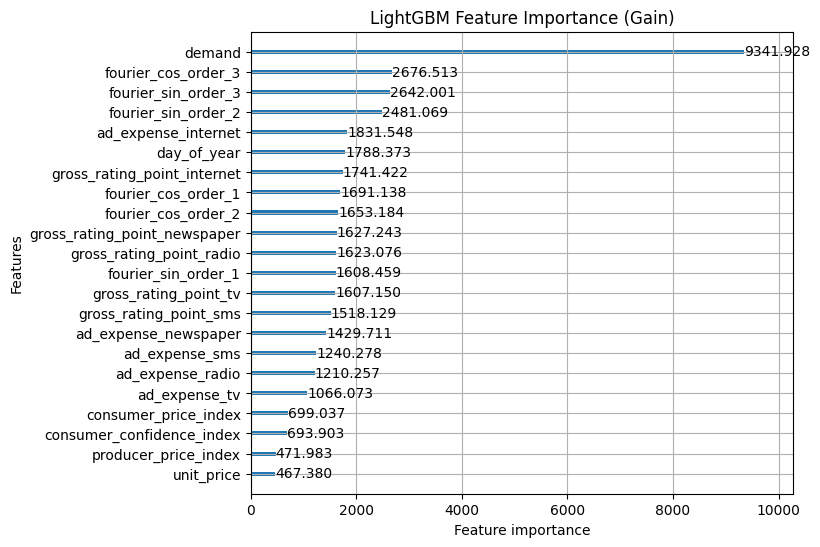

In [10]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

## Model performance for the first 3 months, 6 months, 1 year, 1.5 years, and for the full inference period

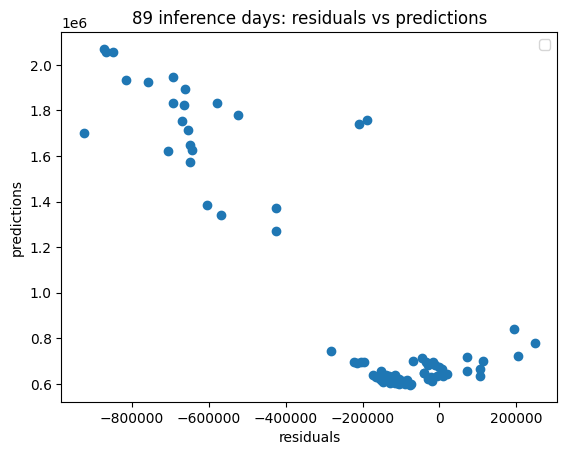

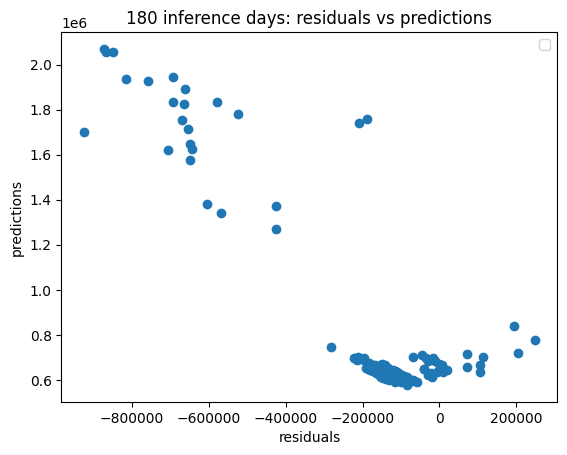

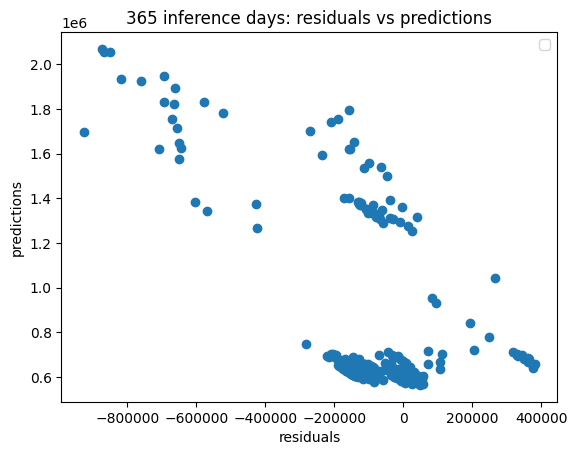

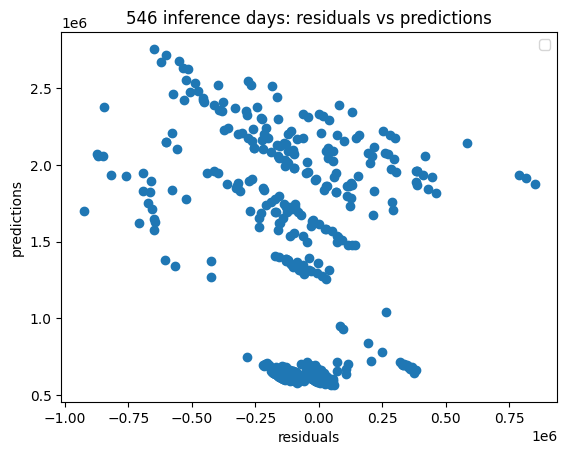

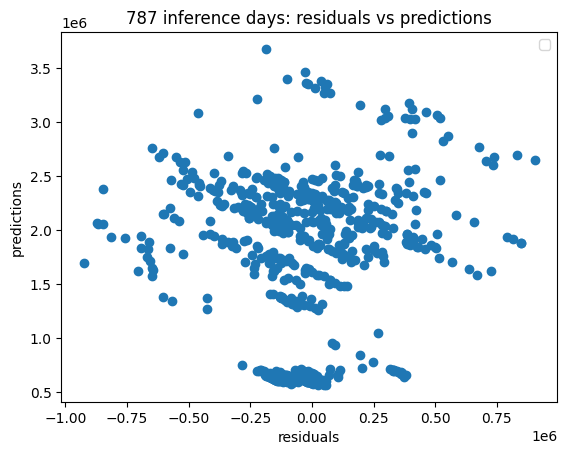

In [11]:
results_list = []
for inf_days in [89,180,365,546,787]:
  y_pred = model.predict(x_test[:inf_days])

  linear_rmse = np.sqrt(mean_squared_error(test_df[y_col][:inf_days], y_pred))
  linear_r2 = r2_score(test_df[y_col][:inf_days], y_pred)
  linear_smape = mean_absolute_percentage_error(test_df[y_col][:inf_days], y_pred, symmetric=True)
  linear_mae = mean_absolute_error(test_df[y_col][:inf_days], y_pred, symmetric=True)

  results_list.append({
      'inference_days': inf_days,
      'rmse': linear_rmse,
      'r2': linear_r2,
      'smape': linear_smape,
      'mae': linear_mae
  })

  residuals = test_df[y_col][:inf_days]-y_pred

  # plt.scatter(residuals,y_pred)

  figure = plt.figure
  ax = plt.gca()
  ax.scatter(residuals, y_pred)
  ax.set_xlabel('residuals')
  ax.set_ylabel('predictions')
  ax.set_title("{} inference days: residuals vs predictions".format(inf_days))

  plt.legend()
  plt.show()

In [12]:
results_df = pd.DataFrame(results_list)
results_df

,inference_days,rmse,r2,smape,mae
0,89,361066.554128,-0.666912,0.258207,252420.244947
1,180,271600.599020,-0.453734,0.246181,191610.099429
2,365,211813.484392,0.450077,0.181779,140505.026258
3,546,244865.365995,0.864990,0.160236,173127.213235
4,787,258038.820726,0.910729,0.139333,186821.920605
